LOADING PROCESSED DATA
✓ Data loaded: 94820 records
Date range: 2015-01-01 00:00:00 to 2025-10-27 07:00:00
Columns: ['timestamp', 'price_eur_mwh', 'year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear', 'week', 'is_holiday', 'is_weekend']

UNIVARIATE ANALYSIS - PRICE DISTRIBUTION

Descriptive Statistics (EUR/MWh):
  Count:           94,820
  Mean:            €72.58
  Median:          €44.95
  Mode:            €22.34
  Std Dev:         €80.70
  Variance:        6512.68
  Coefficient of Variation: 1.112

Distribution Shape:
  Min:             €-316.40
  25th percentile: €30.28
  50th percentile: €44.95
  75th percentile: €89.63
  Max:             €867.85
  IQR:             €59.35

Skewness & Kurtosis:
  Skewness:        3.182
  Kurtosis:        13.985
  Interpretation:  Right-skewed (high outliers)

Normality Test (p-value: 0.0000):
  Normal distribution? No (typical for price data)

OUTLIER DETECTION

IQR Method (1.5 × IQR):
  Lower bound: €-58.75
  Upper bound: €178.66
  Outliers det

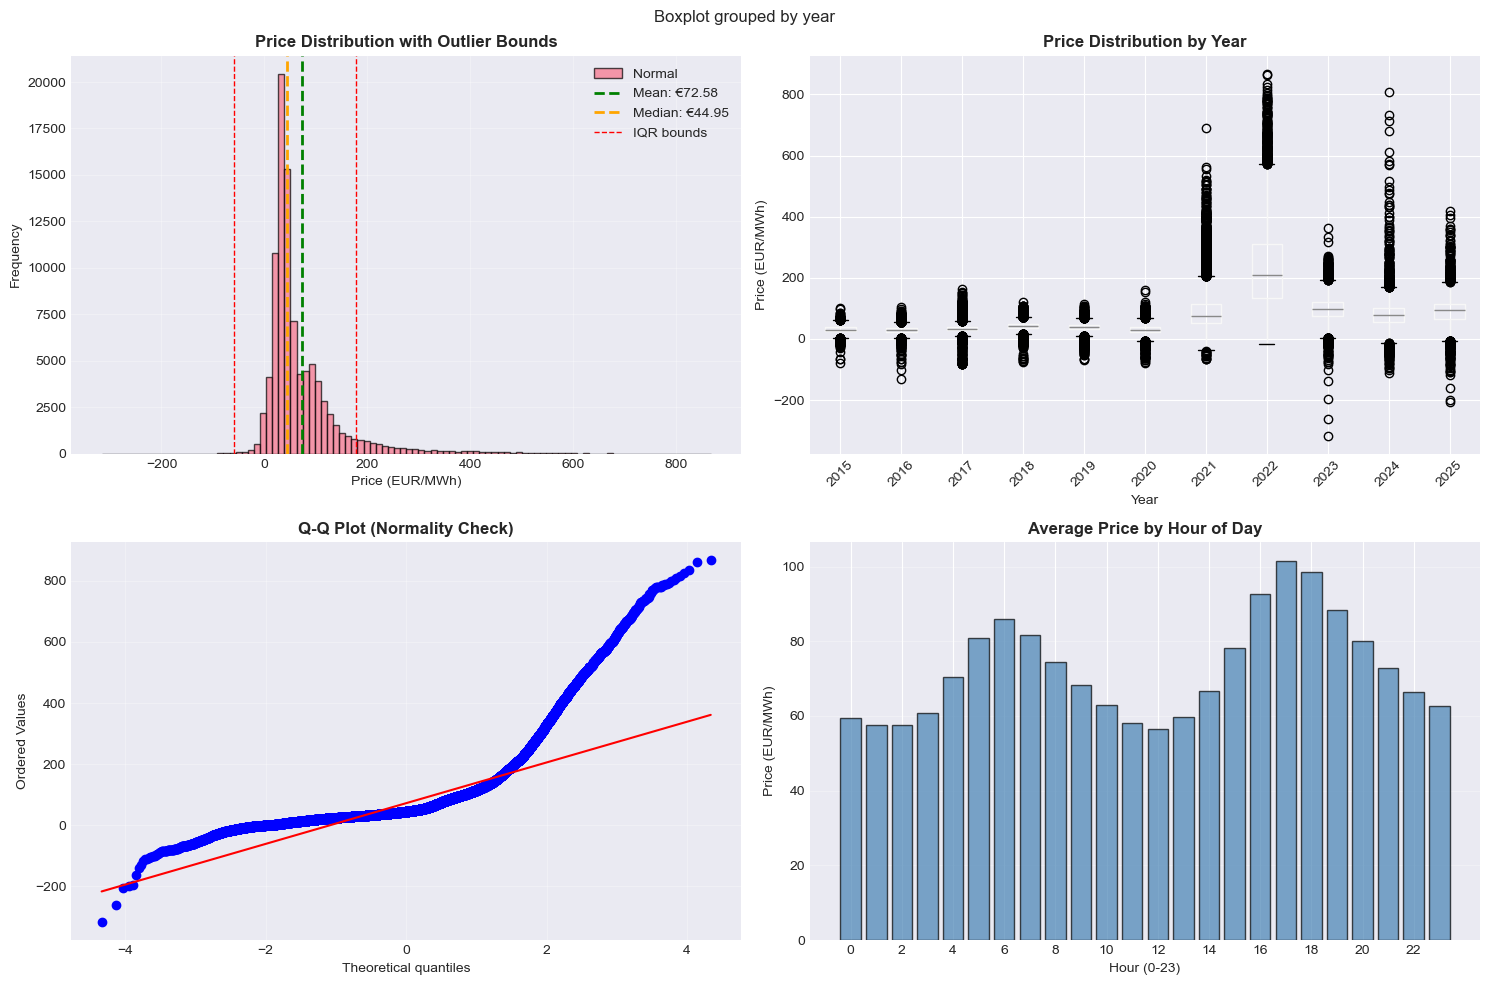

✓ Saved: data/processed/02_temporal_patterns.png


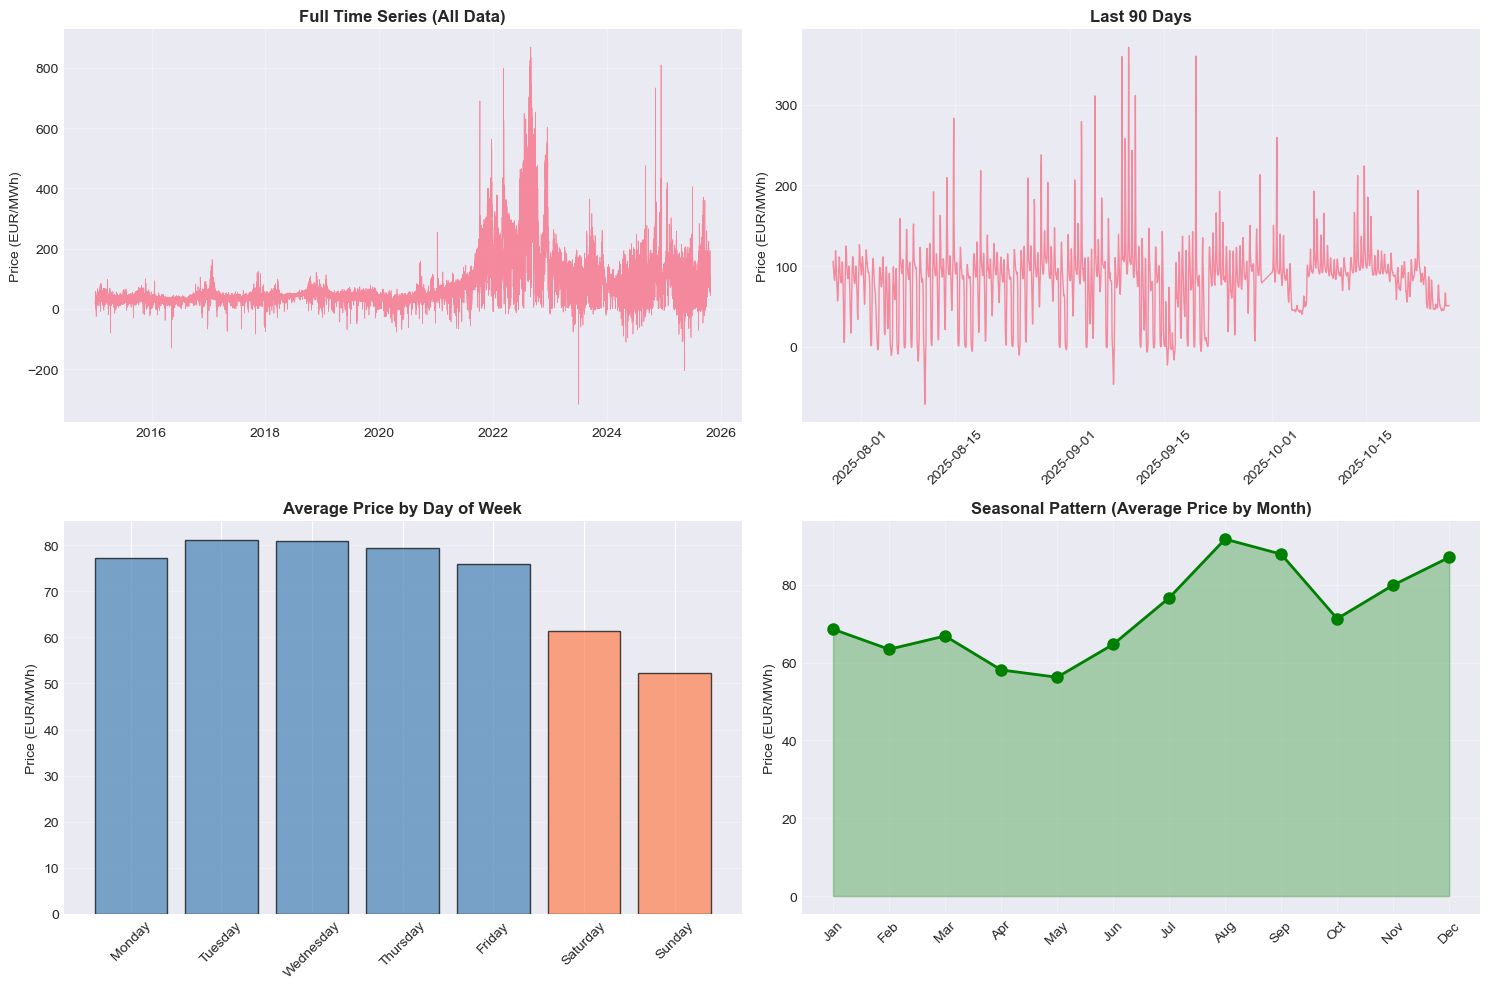

✓ Saved: data/processed/02_decomposition_acf.png


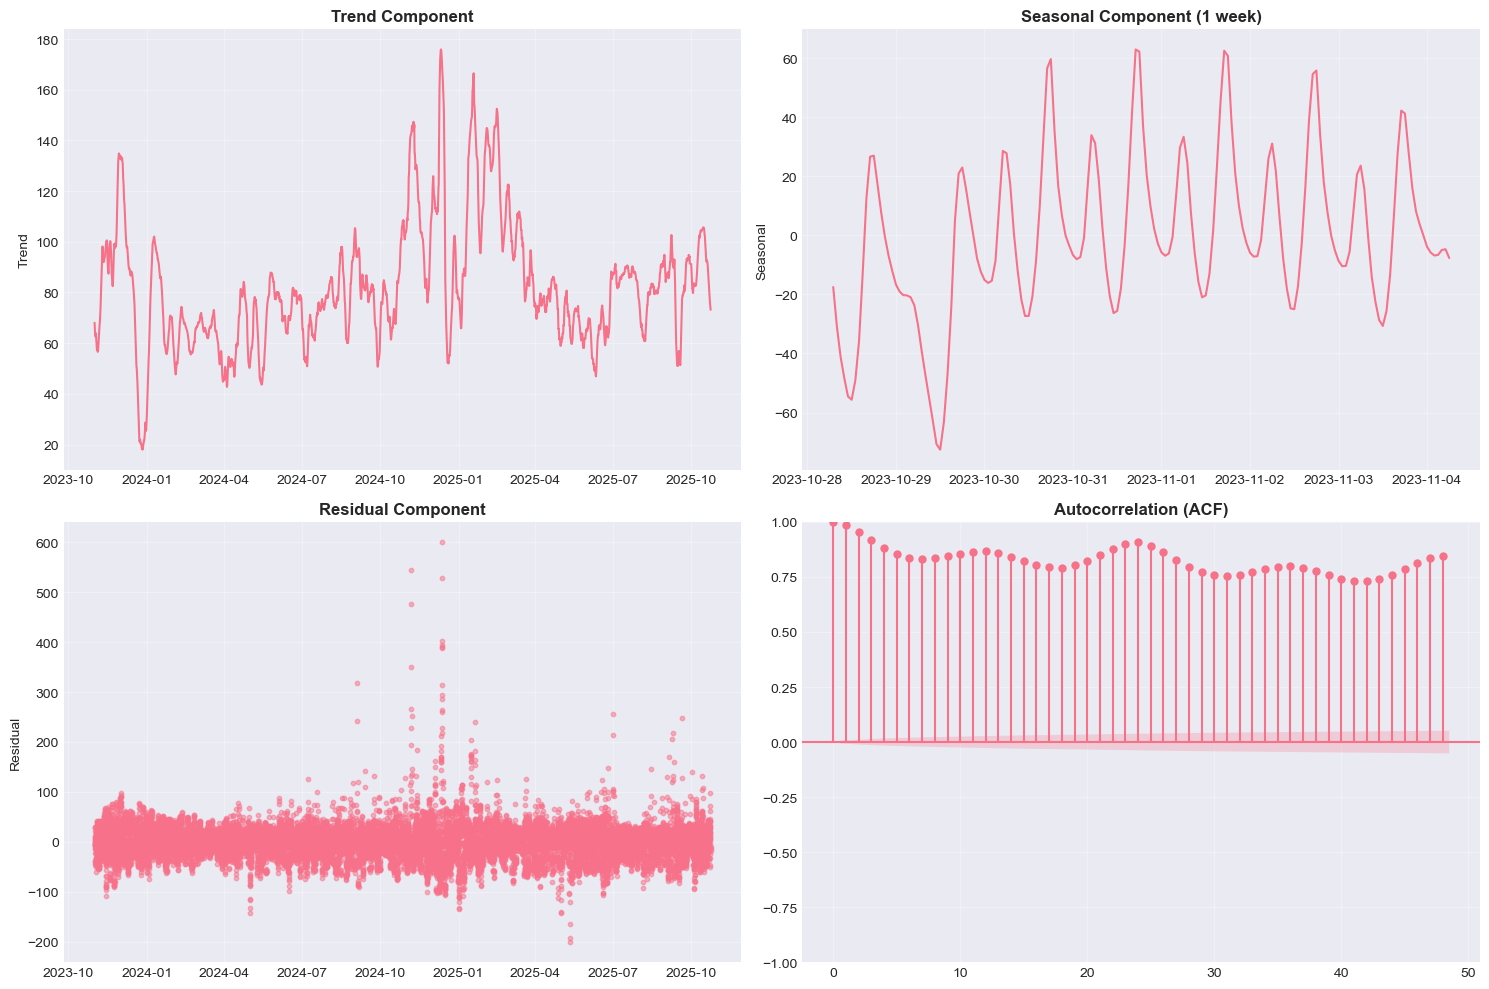

✓ Saved: data/processed/02_outlier_analysis.png


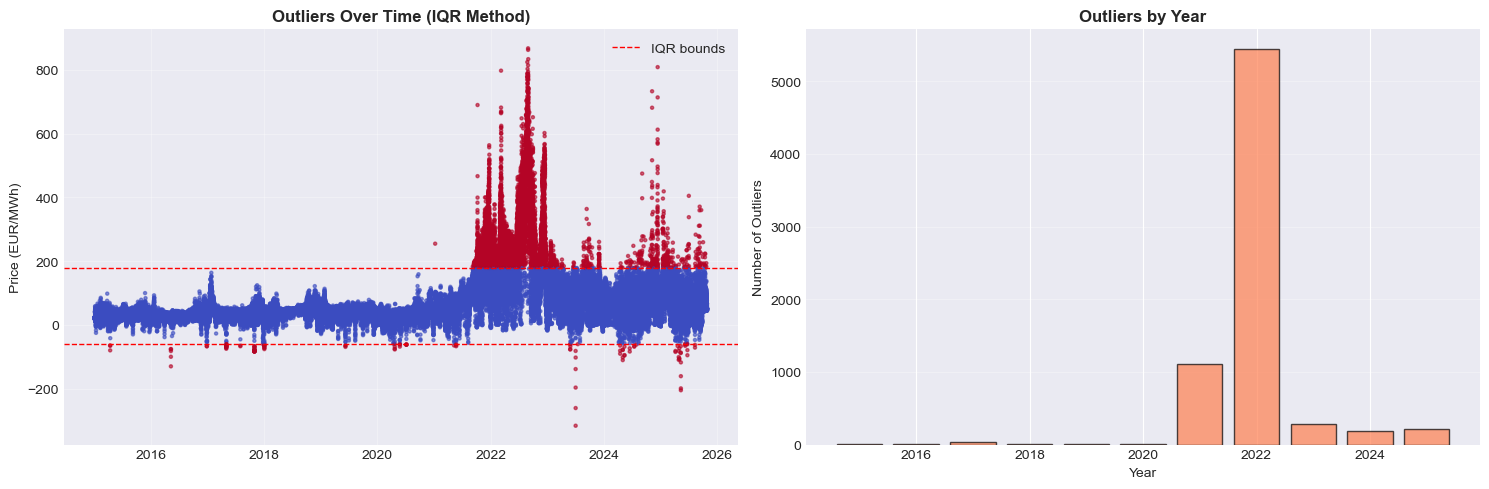


SAVING CLEANED DATA FOR FEATURE ENGINEERING
✓ Saved: data/processed/electricity_prices_cleaned.csv

Data quality summary:
  Total records: 94,820
  Outliers (IQR): 7,297 (7.70%)
  Missing prices: 0

EDA SUMMARY REPORT

KEY FINDINGS:

1. PRICE CHARACTERISTICS
   - Mean: €72.58/MWh
   - Range: €-316.40 to €867.85
   - Volatility (CV): 1.112
   - Distribution: Right-skewed

2. HOURLY PATTERNS
   - Peak hour: 17:00 (€101.51)
   - Off-peak: 12:00 (€56.47)
   - Difference: €45.04

3. WEEKLY PATTERNS
   - Weekday avg: €78.90/MWh
   - Weekend avg: €56.79/MWh
   - Difference: €22.11

4. SEASONAL PATTERNS
   - Cheapest month: May (€56.21)
   - Most expensive: Aug (€91.71)
   - Seasonality strength: €35.50

5. STATIONARITY
   - ADF p-value: 0.000000 (Stationary)
   - Time series shows strong daily patterns

6. OUTLIERS
   - IQR method: 7297 outliers (7.70%)
   - Extreme low: €-316.40 (charging opportunity!)
   - Extreme high: €867.85 (avoid charging)

7. EV CHARGING OPTIMIZATION OPPORTUNITY
   -

In [3]:
# 02_EDA_and_Visualisation.ipynb


"""
EV Charging Optimisation - Exploratory Data Analysis
=====================================================

This notebook performs a comprehensive exploratory data analysis (EDA) on German
electricity prices to understand patterns, trends, seasonality, and outliers.

Key goals:
- Understand price distributions and temporal patterns
- Detect seasonality, trends, and cycles
- Identify outliers and anomalies
- Analyse stationarity (for forecasting)
- Extract actionable insights

Output: Cleaned data with outlier flags for the next stage

"""

# %% 1. SETUP AND IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

warnings.filterwarnings('ignore')

# Set styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data from previous notebook
print("="*70)
print("LOADING PROCESSED DATA")
print("="*70)

df = pd.read_csv('data/raw/electricity_prices_germany.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

print(f"✓ Data loaded: {len(df)} records")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Columns: {list(df.columns)}\n")

# %% 2. UNIVARIATE ANALYSIS - PRICE DISTRIBUTION

print("="*70)
print("UNIVARIATE ANALYSIS - PRICE DISTRIBUTION")
print("="*70)

price = df['price_eur_mwh']

print(f"\nDescriptive Statistics (EUR/MWh):")
print(f"  Count:           {price.count():,}")
print(f"  Mean:            €{price.mean():.2f}")
print(f"  Median:          €{price.median():.2f}")
print(f"  Mode:            €{price.mode().values[0]:.2f}")
print(f"  Std Dev:         €{price.std():.2f}")
print(f"  Variance:        {price.var():.2f}")
print(f"  Coefficient of Variation: {(price.std()/price.mean()):.3f}")

print(f"\nDistribution Shape:")
print(f"  Min:             €{price.min():.2f}")
print(f"  25th percentile: €{price.quantile(0.25):.2f}")
print(f"  50th percentile: €{price.quantile(0.50):.2f}")
print(f"  75th percentile: €{price.quantile(0.75):.2f}")
print(f"  Max:             €{price.max():.2f}")
print(f"  IQR:             €{(price.quantile(0.75) - price.quantile(0.25)):.2f}")

print(f"\nSkewness & Kurtosis:")
skewness = stats.skew(price.dropna())
kurtosis = stats.kurtosis(price.dropna())
print(f"  Skewness:        {skewness:.3f}")
print(f"  Kurtosis:        {kurtosis:.3f}")
print(f"  Interpretation:  ", end="")
if abs(skewness) < 0.5:
    print("Fairly symmetric")
elif skewness > 0.5:
    print("Right-skewed (high outliers)")
else:
    print("Left-skewed (low outliers)")

# Normality test
_, p_value = stats.normaltest(price.dropna())
print(f"\nNormality Test (p-value: {p_value:.4f}):")
print(f"  Normal distribution? {'Yes' if p_value > 0.05 else 'No (typical for price data)'}")

# %% 3. OUTLIER DETECTION

print("\n" + "="*70)
print("OUTLIER DETECTION")
print("="*70)

# Method 1: IQR (Interquartile Range)
Q1 = price.quantile(0.25)
Q3 = price.quantile(0.75)
IQR = Q3 - Q1
outlier_low_iqr = Q1 - 1.5 * IQR
outlier_high_iqr = Q3 + 1.5 * IQR

outliers_iqr = df[(df['price_eur_mwh'] < outlier_low_iqr) | 
                   (df['price_eur_mwh'] > outlier_high_iqr)]

print(f"\nIQR Method (1.5 × IQR):")
print(f"  Lower bound: €{outlier_low_iqr:.2f}")
print(f"  Upper bound: €{outlier_high_iqr:.2f}")
print(f"  Outliers detected: {len(outliers_iqr)} ({(len(outliers_iqr)/len(df)*100):.2f}%)")

if len(outliers_iqr) > 0:
    print(f"  Extreme low: €{outliers_iqr['price_eur_mwh'].min():.2f} (good for EV charging!)")
    print(f"  Extreme high: €{outliers_iqr['price_eur_mwh'].max():.2f} (avoid charging)")

# Method 2: Z-score
z_scores = np.abs(stats.zscore(price.dropna()))
outliers_zscore = df[np.abs(stats.zscore(df['price_eur_mwh'].fillna(df['price_eur_mwh'].mean()))) > 3]

print(f"\nZ-Score Method (|Z| > 3):")
print(f"  Outliers detected: {len(outliers_zscore)} ({(len(outliers_zscore)/len(df)*100):.2f}%)")

# Add outlier flag to dataframe
df['is_outlier_iqr'] = (df['price_eur_mwh'] < outlier_low_iqr) | (df['price_eur_mwh'] > outlier_high_iqr)
df['is_outlier_zscore'] = np.abs(stats.zscore(df['price_eur_mwh'].fillna(df['price_eur_mwh'].mean()))) > 3

print(f"\n✓ Outlier flags added to dataframe")

# %% 4. TEMPORAL PATTERNS - HOURLY ANALYSIS

print("\n" + "="*70)
print("TEMPORAL PATTERNS - HOURLY ANALYSIS")
print("="*70)

hourly_stats = df.groupby('hour')['price_eur_mwh'].agg([
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('count', 'count')
]).round(2)

print("\nPrice by Hour of Day:")
print(hourly_stats)

# Find cheapest and most expensive hours
cheapest_hour = hourly_stats['mean'].idxmin()
most_expensive_hour = hourly_stats['mean'].idxmax()

print(f"\n💡 Insights:")
print(f"  Cheapest hour: {cheapest_hour:02d}:00 (€{hourly_stats.loc[cheapest_hour, 'mean']:.2f})")
print(f"  Most expensive: {most_expensive_hour:02d}:00 (€{hourly_stats.loc[most_expensive_hour, 'mean']:.2f})")
print(f"  Price difference: €{(hourly_stats.loc[most_expensive_hour, 'mean'] - hourly_stats.loc[cheapest_hour, 'mean']):.2f}")

# %% 5. DAILY PATTERNS - DAY OF WEEK ANALYSIS

print("\n" + "="*70)
print("TEMPORAL PATTERNS - DAY OF WEEK ANALYSIS")
print("="*70)

dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_stats = df.groupby('dayofweek')['price_eur_mwh'].agg([
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
]).round(2)
dow_stats.index = dow_names

print("\nPrice by Day of Week:")
print(dow_stats)

cheapest_dow = dow_stats['mean'].idxmin()
most_expensive_dow = dow_stats['mean'].idxmax()

print(f"\n💡 Insights:")
print(f"  Cheapest day: {cheapest_dow} (€{dow_stats.loc[cheapest_dow, 'mean']:.2f})")
print(f"  Most expensive: {most_expensive_dow} (€{dow_stats.loc[most_expensive_dow, 'mean']:.2f})")

# %% 6. SEASONAL PATTERNS - MONTHLY AND YEARLY ANALYSIS

print("\n" + "="*70)
print("SEASONAL PATTERNS - MONTHLY ANALYSIS")
print("="*70)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_stats = df.groupby('month')['price_eur_mwh'].agg([
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
]).round(2)
monthly_stats.index = month_names

print("\nPrice by Month:")
print(monthly_stats)

cheapest_month = monthly_stats['mean'].idxmin()
most_expensive_month = monthly_stats['mean'].idxmax()

print(f"\n💡 Insights:")
print(f"  Cheapest month: {cheapest_month} (€{monthly_stats.loc[cheapest_month, 'mean']:.2f})")
print(f"  Most expensive: {most_expensive_month} (€{monthly_stats.loc[most_expensive_month, 'mean']:.2f})")
print(f"  Seasonality range: €{(monthly_stats['mean'].max() - monthly_stats['mean'].min()):.2f}")

# Yearly analysis
print("\n" + "-"*70)
print("Yearly Trends:")
yearly_stats = df.groupby('year')['price_eur_mwh'].agg([
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('count', 'count')
]).round(2)

print(yearly_stats)

# %% 7. STATIONARITY TESTS

print("\n" + "="*70)
print("STATIONARITY TESTS (for forecasting)")
print("="*70)

# Augmented Dickey-Fuller Test
adf_result = adfuller(df['price_eur_mwh'].dropna(), autolag='AIC')

print("\nAugmented Dickey-Fuller Test:")
print(f"  ADF Statistic:     {adf_result[0]:.6f}")
print(f"  P-value:           {adf_result[1]:.6f}")
print(f"  Lags Used:         {adf_result[2]}")
print(f"  Observations:      {adf_result[3]}")
print(f"  Critical Values:")
for key, value in adf_result[4].items():
    print(f"    {key}: {value:.4f}")

if adf_result[1] < 0.05:
    print(f"\n  ✓ Series is STATIONARY (p < 0.05)")
    print(f"    Can use ARIMA models directly")
else:
    print(f"\n  ✗ Series is NON-STATIONARY (p ≥ 0.05)")
    print(f"    Need differencing or other methods")

# KPSS Test
kpss_result = kpss(df['price_eur_mwh'].dropna(), regression='c', nlags='auto')

print(f"\nKPSS Test:")
print(f"  KPSS Statistic:    {kpss_result[0]:.6f}")
print(f"  P-value:           {kpss_result[1]:.6f}")
print(f"  Lags Used:         {kpss_result[2]}")

if kpss_result[1] > 0.05:
    print(f"  ✓ Series is STATIONARY")
else:
    print(f"  ✗ Series is NON-STATIONARY (needs differencing)")

# %% 8. AUTOCORRELATION ANALYSIS

print("\n" + "="*70)
print("AUTOCORRELATION ANALYSIS")
print("="*70)

# Calculate ACF and PACF
acf_values = acf(df['price_eur_mwh'].dropna(), nlags=168, fft=False)
pacf_values = pacf(df['price_eur_mwh'].dropna(), nlags=168, method='ywm')

print("\nAutocorrelation (ACF) at key lags:")
for lag in [1, 24, 48, 168, 336]:
    if lag < len(acf_values):
        print(f"  Lag {lag:3d}h: {acf_values[lag]:7.4f}")

print("\nInterpretation:")
if abs(acf_values[24]) > 0.5:
    print("  ✓ Strong 24-hour cyclical pattern (intraday repeats)")
if abs(acf_values[168]) > 0.5:
    print("  ✓ Strong 7-day (weekly) pattern")

# %% 9. CORRELATION WITH TEMPORAL FEATURES

print("\n" + "="*70)
print("CORRELATION WITH TEMPORAL FEATURES")
print("="*70)

correlation_features = ['hour', 'dayofweek', 'dayofyear', 'month', 'is_weekend', 'is_holiday']
correlations = df[correlation_features + ['price_eur_mwh']].corr()['price_eur_mwh'].drop('price_eur_mwh')

print("\nPearson Correlation with Price:")
correlations_sorted = correlations.sort_values(ascending=False)
for feature, corr in correlations_sorted.items():
    print(f"  {feature:15s}: {corr:7.4f}")

# %% 10. NEGATIVE PRICES ANALYSIS (KEY FOR EV OPTIMIZATION)

print("\n" + "="*70)
print("NEGATIVE PRICES ANALYSIS (Opportunity for EV Charging!)")
print("="*70)

neg_prices = df[df['price_eur_mwh'] < 0]

print(f"\nNegative Price Hours:")
print(f"  Total occurrences: {len(neg_prices)} hours ({(len(neg_prices)/len(df)*100):.2f}%)")
print(f"  Minimum price:     €{neg_prices['price_eur_mwh'].min():.2f}/MWh")
print(f"  Maximum (most negative): €{neg_prices['price_eur_mwh'].max():.2f}/MWh")

if len(neg_prices) > 0:
    print(f"\nWhen do negative prices occur?")
    print(f"  Most common hour: {neg_prices['hour'].mode().values[0]}:00")
    print(f"  Most common month: {month_names[neg_prices['month'].mode().values[0]-1]}")
    print(f"  Most common day: {dow_names[neg_prices['dayofweek'].mode().values[0]]}")
    
    print(f"\n💡 OPTIMIZATION INSIGHT:")
    print(f"  - Potential annual savings if EV charges during negative prices")
    avg_charge_kwh = 60  # 60 kWh typical EV
    charging_hours_yearly = len(neg_prices)
    savings = neg_prices['price_eur_mwh'].mean() * avg_charge_kwh / 1000 * charging_hours_yearly
    print(f"  - Estimated saving: €{savings:.2f}/year (assuming {charging_hours_yearly} charging opportunities)")

# %% 11. MISSING DATA AND DATA QUALITY

print("\n" + "="*70)
print("MISSING DATA AND DATA QUALITY")
print("="*70)

print(f"\nMissing Values:")
print(f"  Price column: {df['price_eur_mwh'].isna().sum()} missing")
print(f"  Percentage: {(df['price_eur_mwh'].isna().sum()/len(df)*100):.4f}%")

print(f"\nTime series continuity:")
time_diffs = df['timestamp'].diff().dt.total_seconds() / 3600
print(f"  Expected: 1 hour between records")
print(f"  Actual distribution:")
print(f"    Most common gap: {time_diffs.mode().values[0]} hours")
print(f"    Max gap: {time_diffs.max()} hours")
print(f"    Non-hourly records: {(time_diffs != 1).sum()}")

# %% 12. DECOMPOSITION

print("\n" + "="*70)
print("TIME SERIES DECOMPOSITION")
print("="*70)

# Use last 2 years for clearer visualization
recent_data = df[df['timestamp'] >= df['timestamp'].max() - pd.Timedelta(days=730)].copy()
recent_data = recent_data.set_index('timestamp')['price_eur_mwh'].sort_index()

print(f"Decomposing: {recent_data.index.min()} to {recent_data.index.max()}")

try:
    decomposition = seasonal_decompose(recent_data, model='additive', period=24*7)  # 7-day cycle
    print("✓ Decomposition successful")
    print(f"  Trend range: €{decomposition.trend.min():.2f} to €{decomposition.trend.max():.2f}")
    print(f"  Seasonal range: €{decomposition.seasonal.min():.2f} to €{decomposition.seasonal.max():.2f}")
    print(f"  Residual std: €{decomposition.resid.std():.2f}")
except Exception as e:
    print(f"✗ Decomposition failed: {e}")
    decomposition = None

# %% 13. VISUALIZATION - COMPREHENSIVE

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Figure 1: Distribution and Outliers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram with outliers
ax = axes[0, 0]
ax.hist(df['price_eur_mwh'], bins=100, alpha=0.7, edgecolor='black', label='Normal')
ax.axvline(price.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: €{price.mean():.2f}')
ax.axvline(price.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: €{price.median():.2f}')
ax.axvline(outlier_low_iqr, color='red', linestyle='--', linewidth=1, label='IQR bounds')
ax.axvline(outlier_high_iqr, color='red', linestyle='--', linewidth=1)
ax.set_title('Price Distribution with Outlier Bounds', fontsize=12, fontweight='bold')
ax.set_xlabel('Price (EUR/MWh)')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.3)

# Box plot by year
ax = axes[0, 1]
df.boxplot(column='price_eur_mwh', by='year', ax=ax)
ax.set_title('Price Distribution by Year', fontsize=12, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Price (EUR/MWh)')
plt.sca(ax)
plt.xticks(rotation=45)

# Q-Q plot
ax = axes[1, 0]
stats.probplot(price.dropna(), dist="norm", plot=ax)
ax.set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Scatter plot: Price vs Hour
ax = axes[1, 1]
hour_means = df.groupby('hour')['price_eur_mwh'].mean()
ax.bar(hour_means.index, hour_means.values, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_title('Average Price by Hour of Day', fontsize=12, fontweight='bold')
ax.set_xlabel('Hour (0-23)')
ax.set_ylabel('Price (EUR/MWh)')
ax.set_xticks(range(0, 24, 2))
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('data/processed/02_distribution_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: data/processed/02_distribution_analysis.png")
plt.show()

# Figure 2: Temporal Patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Time series (all data)
ax = axes[0, 0]
ax.plot(df['timestamp'], df['price_eur_mwh'], linewidth=0.5, alpha=0.8)
ax.set_title('Full Time Series (All Data)', fontsize=12, fontweight='bold')
ax.set_ylabel('Price (EUR/MWh)')
ax.grid(alpha=0.3)

# Time series (last 90 days)
ax = axes[0, 1]
recent_90 = df.tail(90*24)
ax.plot(recent_90['timestamp'], recent_90['price_eur_mwh'], linewidth=1, alpha=0.8)
ax.set_title('Last 90 Days', fontsize=12, fontweight='bold')
ax.set_ylabel('Price (EUR/MWh)')
ax.grid(alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Day of week pattern
ax = axes[1, 0]
dow_means = df.groupby('dayofweek')['price_eur_mwh'].mean()
colors = ['steelblue' if i < 5 else 'coral' for i in range(7)]
ax.bar(range(7), dow_means.values, color=colors, edgecolor='black', alpha=0.7)
ax.set_xticks(range(7))
ax.set_xticklabels(dow_names, rotation=45)
ax.set_title('Average Price by Day of Week', fontsize=12, fontweight='bold')
ax.set_ylabel('Price (EUR/MWh)')
ax.grid(axis='y', alpha=0.3)

# Monthly pattern
ax = axes[1, 1]
monthly_means = df.groupby('month')['price_eur_mwh'].mean()
ax.plot(range(1, 13), monthly_means.values, marker='o', linewidth=2, markersize=8, color='green')
ax.fill_between(range(1, 13), monthly_means.values, alpha=0.3, color='green')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names, rotation=45)
ax.set_title('Seasonal Pattern (Average Price by Month)', fontsize=12, fontweight='bold')
ax.set_ylabel('Price (EUR/MWh)')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('data/processed/02_temporal_patterns.png', dpi=300, bbox_inches='tight')
print("✓ Saved: data/processed/02_temporal_patterns.png")
plt.show()

# Figure 3: ACF and PACF
if decomposition is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Trend
    ax = axes[0, 0]
    ax.plot(decomposition.trend.index, decomposition.trend.values, linewidth=1.5)
    ax.set_title('Trend Component', fontsize=12, fontweight='bold')
    ax.set_ylabel('Trend')
    ax.grid(alpha=0.3)
    
    # Seasonal
    ax = axes[0, 1]
    ax.plot(decomposition.seasonal.index[:7*24], decomposition.seasonal.values[:7*24], linewidth=1.5)
    ax.set_title('Seasonal Component (1 week)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Seasonal')
    ax.grid(alpha=0.3)
    
    # Residual
    ax = axes[1, 0]
    ax.scatter(decomposition.resid.index, decomposition.resid.values, alpha=0.5, s=10)
    ax.set_title('Residual Component', fontsize=12, fontweight='bold')
    ax.set_ylabel('Residual')
    ax.grid(alpha=0.3)
    
    # ACF
    ax = axes[1, 1]
    plot_acf(df['price_eur_mwh'].dropna(), lags=48, ax=ax)
    ax.set_title('Autocorrelation (ACF)', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('data/processed/02_decomposition_acf.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: data/processed/02_decomposition_acf.png")
    plt.show()

# Figure 4: Outliers Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Outliers time series
ax = axes[0]
ax.scatter(df['timestamp'], df['price_eur_mwh'], c=df['is_outlier_iqr'], 
           cmap='coolwarm', s=5, alpha=0.6)
ax.axhline(outlier_low_iqr, color='red', linestyle='--', linewidth=1, label='IQR bounds')
ax.axhline(outlier_high_iqr, color='red', linestyle='--', linewidth=1)
ax.set_title('Outliers Over Time (IQR Method)', fontsize=12, fontweight='bold')
ax.set_ylabel('Price (EUR/MWh)')
ax.grid(alpha=0.3)
ax.legend()

# Outlier distribution
ax = axes[1]
outlier_counts = df.groupby('year')['is_outlier_iqr'].sum()
ax.bar(outlier_counts.index, outlier_counts.values, color='coral', edgecolor='black', alpha=0.7)
ax.set_title('Outliers by Year', fontsize=12, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Outliers')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('data/processed/02_outlier_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: data/processed/02_outlier_analysis.png")
plt.show()

# %% 14. SAVE CLEANED DATA

print("\n" + "="*70)
print("SAVING CLEANED DATA FOR FEATURE ENGINEERING")
print("="*70)

# Save with outlier flags
output_path = 'data/processed/electricity_prices_cleaned.csv'
df.to_csv(output_path, index=False)
print(f"✓ Saved: {output_path}")

print(f"\nData quality summary:")
print(f"  Total records: {len(df):,}")
print(f"  Outliers (IQR): {df['is_outlier_iqr'].sum():,} ({(df['is_outlier_iqr'].sum()/len(df)*100):.2f}%)")
print(f"  Missing prices: {df['price_eur_mwh'].isna().sum()}")

# %% 15. SUMMARY REPORT

print("\n" + "="*70)
print("EDA SUMMARY REPORT")
print("="*70)

summary = f"""
KEY FINDINGS:
=============

1. PRICE CHARACTERISTICS
   - Mean: €{price.mean():.2f}/MWh
   - Range: €{price.min():.2f} to €{price.max():.2f}
   - Volatility (CV): {(price.std()/price.mean()):.3f}
   - Distribution: {'Right-skewed' if skewness > 0.5 else 'Fairly symmetric'}

2. HOURLY PATTERNS
   - Peak hour: {most_expensive_hour:02d}:00 (€{hourly_stats.loc[most_expensive_hour, 'mean']:.2f})
   - Off-peak: {cheapest_hour:02d}:00 (€{hourly_stats.loc[cheapest_hour, 'mean']:.2f})
   - Difference: €{(hourly_stats.loc[most_expensive_hour, 'mean'] - hourly_stats.loc[cheapest_hour, 'mean']):.2f}

3. WEEKLY PATTERNS
   - Weekday avg: €{df[df['is_weekend']==0]['price_eur_mwh'].mean():.2f}/MWh
   - Weekend avg: €{df[df['is_weekend']==1]['price_eur_mwh'].mean():.2f}/MWh
   - Difference: €{abs(df[df['is_weekend']==0]['price_eur_mwh'].mean() - df[df['is_weekend']==1]['price_eur_mwh'].mean()):.2f}

4. SEASONAL PATTERNS
   - Cheapest month: {cheapest_month} (€{monthly_stats.loc[cheapest_month, 'mean']:.2f})
   - Most expensive: {most_expensive_month} (€{monthly_stats.loc[most_expensive_month, 'mean']:.2f})
   - Seasonality strength: €{(monthly_stats['mean'].max() - monthly_stats['mean'].min()):.2f}

5. STATIONARITY
   - ADF p-value: {adf_result[1]:.6f} ({'Stationary' if adf_result[1] < 0.05 else 'Non-stationary'})
   - Time series shows {'strong' if abs(acf_values[24]) > 0.5 else 'weak'} daily patterns

6. OUTLIERS
   - IQR method: {len(outliers_iqr)} outliers ({(len(outliers_iqr)/len(df)*100):.2f}%)
   - Extreme low: €{outliers_iqr['price_eur_mwh'].min():.2f} (charging opportunity!)
   - Extreme high: €{outliers_iqr['price_eur_mwh'].max():.2f} (avoid charging)

7. EV CHARGING OPTIMIZATION OPPORTUNITY
   - Negative price hours: {len(neg_prices)} ({(len(neg_prices)/len(df)*100):.2f}%)
   - Potential annual savings: €{savings:.2f} (60 kWh EV)
   - Best months: {neg_prices['month'].mode().values[0]} (renewable surplus season)

RECOMMENDATIONS FOR FORECASTING:
=================================
✓ Use ARIMA/SARIMA (captured seasonal patterns)
✓ Try XGBoost/LightGBM (handles hourly patterns well)
✓ Feature engineer: hour, day_of_week, month, holidays
✓ Handle outliers: keep for training (they're real market events)
✓ 72-hour forecast window: sufficient for EV optimization
✓ Focus prediction on high-variance hours ({most_expensive_hour:02d}:00)

NEXT STEPS:
===========
→ Run 03_feature_engineering.ipynb
"""

print(summary)

# Save report
with open('data/processed/EDA_REPORT.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print("\n✓ Report saved: data/processed/EDA_REPORT.txt")
print("✓✓✓ EDA COMPLETE ✓✓✓")
print("\nReady for: 03_feature_engineering.ipynb")